<a href="https://colab.research.google.com/github/KillShotAK/UoS-Forex-Trading-Robot/blob/main/Robertadistillembedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required libraries
!pip install transformers pandas openpyxl sentence-transformers scikit-learn

import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle

# Load the data
df = pd.read_excel('/content/EURUSD_news.xlsx')

# Set up the sentiment model
sentiment_model_name = "mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(sentiment_model_name)
sentiment_model = AutoModelForSequenceClassification.from_pretrained(sentiment_model_name)

# Set up the embedding model
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

# Function to get sentiment
def get_sentiment(text):
    if not isinstance(text, str):
        return "invalid"
    if pd.isna(text) or text.strip() == "":
        return "invalid"
    try:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512, padding=True)
        outputs = sentiment_model(**inputs)
        probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
        sentiment = torch.argmax(probabilities).item()
        return ["Neutral", "Positive", "Negative"][sentiment]
    except Exception as e:
        print(f"Error processing text: {text[:50]}... Error: {str(e)}")
        return "error"

# Function to get embedding
def get_embedding(text):
    if not isinstance(text, str):
        return np.zeros(384)  # Return zero vector for invalid input
    return embedding_model.encode(text)

# Clean the data
df['articleBody'] = df['articleBody'].astype(str).replace('nan', np.nan)

# Perform sentiment analysis
df['sentiment'] = df['articleBody'].apply(get_sentiment)

# Define a mapping for categories to numerical values
category_to_number = {
    'Positive': 2,
    'Neutral': 1,
    'Negative': 0
}

# Convert categories to numerical values
df['sentiment_score'] = df['sentiment'].map(category_to_number)

# Generate embeddings for 'title' and 'articleBody' columns
df['title_embedding'] = df['title'].apply(get_embedding)
df['article_embedding'] = df['articleBody'].apply(get_embedding)

# Combine title and article embeddings
df['combined_embedding'] = df.apply(lambda row: np.concatenate([row['title_embedding'], row['article_embedding']]), axis=1)

# Calculate tail risk features (assuming 'return' column exists)
if 'return' in df.columns:
    df['tail_risk'] = df.groupby('date')['return'].transform(lambda x: x.quantile(0.05))
    df['tail_risk_deviation'] = df['return'] - df['tail_risk']
else:
    print("Warning: 'return' column not found. Skipping tail risk calculation.")
    df['tail_risk'] = np.nan
    df['tail_risk_deviation'] = np.nan

# Prepare features and target
X = np.concatenate([np.stack(df['combined_embedding'].values),
                    df[['sentiment_score', 'tail_risk', 'tail_risk_deviation']].values], axis=1)
y = df['return'].values if 'return' in df.columns else np.zeros(len(df))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the converted data to a CSV file
converted_df = pd.DataFrame(X, columns=[f'embedding_{i}' for i in range(X.shape[1] - 3)] +
                            ['sentiment_score', 'tail_risk', 'tail_risk_deviation'])
converted_df['return'] = y
converted_df.to_csv('converted_data.csv', index=False)

# Save the train and test data as separate pickle files
pickle.dump(X_train_scaled, open('/content/EURUSD_news_X_train.pkl', 'wb'))
pickle.dump(y_train, open('/content/EURUSD_news_y_train.pkl', 'wb'))
pickle.dump(X_test_scaled, open('/content/EURUSD_news_X_test.pkl', 'wb'))
pickle.dump(y_test, open('/content/EURUSD_news_y_test.pkl', 'wb'))

print("\nPickle files saved:")
print("- /content/EURUSD_news_X_train.pkl: Contains scaled training features")
print("- /content/EURUSD_news_y_train.pkl: Contains training target values")
print("- /content/EURUSD_news_X_test.pkl: Contains scaled testing features")
print("- /content/EURUSD_news_y_test.pkl: Contains testing target values")

# Save results to Excel
output_file_path = '/content/EURUSD_news_with_sentiment_and_embeddings.xlsx'
df.to_excel(output_file_path, index=False)
print(f"\nResults saved to '{output_file_path}'")

# Print some statistics
print("\nData Statistics:")
print(f"Total rows: {len(df)}")
print(f"Rows with valid sentiment: {len(df[df['sentiment'].isin(['Positive', 'Negative', 'Neutral'])])}")
print(f"Rows with invalid data: {len(df[df['sentiment'] == 'invalid'])}")
print(f"Rows with processing errors: {len(df[df['sentiment'] == 'error'])}")

# Sample of problematic rows
print("\nSample of rows with issues:")
problem_rows = df[df['sentiment'].isin(['invalid', 'error'])].head()
print(problem_rows[['title', 'articleBody', 'sentiment']])

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count



Pickle files saved:
- /content/EURUSD_news_X_train.pkl: Contains scaled training features
- /content/EURUSD_news_y_train.pkl: Contains training target values
- /content/EURUSD_news_X_test.pkl: Contains scaled testing features
- /content/EURUSD_news_y_test.pkl: Contains testing target values

Results saved to '/content/EURUSD_news_with_sentiment_and_embeddings.xlsx'

Data Statistics:
Total rows: 7413
Rows with valid sentiment: 7412
Rows with invalid data: 1
Rows with processing errors: 0

Sample of rows with issues:
                                                 title articleBody sentiment
211  Breaking News: US Dollar knee jerks lower afte...         NaN   invalid


Sentiment Counts:
Negative: 3638
Neutral: 3231
Positive: 543
invalid: 1


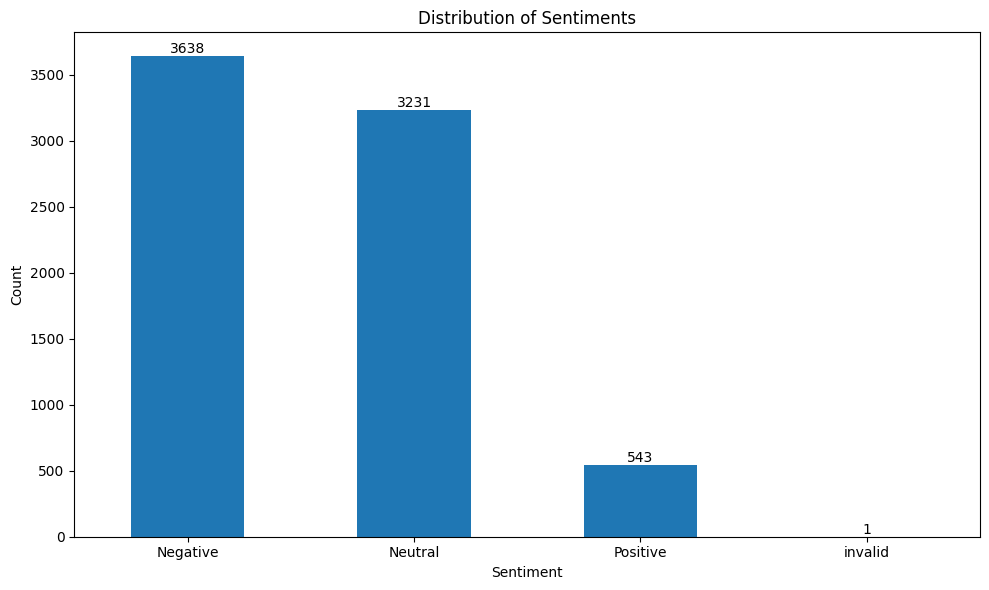

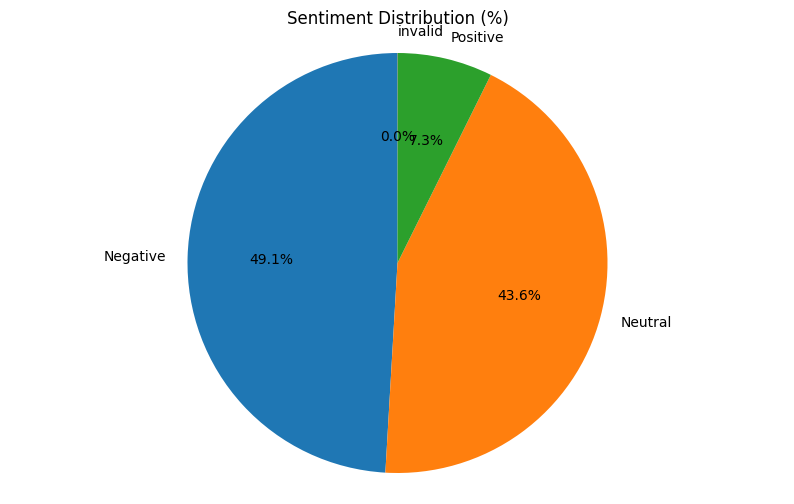


Additional Statistics:
Total articles analyzed: 7413
Most common sentiment: Negative (3638 articles)
Least common sentiment: invalid (1 articles)
Ratio of positive to negative: 0.15


In [ ]:
import matplotlib.pyplot as plt

# Count the number of positive, negative, and neutral sentiments
sentiment_counts = df['sentiment'].value_counts()

# Print the counts
print("Sentiment Counts:")
for sentiment, count in sentiment_counts.items():
    print(f"{sentiment}: {count}")

# Create a bar plot
plt.figure(figsize=(10, 6))
sentiment_counts.plot(kind='bar')
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Add value labels on top of each bar
for i, v in enumerate(sentiment_counts):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Calculate percentages
total = sentiment_counts.sum()
sentiment_percentages = (sentiment_counts / total * 100).round(2)

# Create a pie chart
plt.figure(figsize=(10, 6))
plt.pie(sentiment_percentages, labels=sentiment_percentages.index, autopct='%1.1f%%', startangle=90)
plt.title('Sentiment Distribution (%)')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

# Print some additional statistics
print("\nAdditional Statistics:")
print(f"Total articles analyzed: {total}")
print(f"Most common sentiment: {sentiment_counts.index[0]} ({sentiment_counts.iloc[0]} articles)")
print(f"Least common sentiment: {sentiment_counts.index[-1]} ({sentiment_counts.iloc[-1]} articles)")
print(f"Ratio of positive to negative: {sentiment_counts.get('Positive', 0) / sentiment_counts.get('Negative', 1):.2f}")